# 1. Import library dan dataset

In [1]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

#Reading datasets
#main dataset
df = pd.read_csv('covid.csv')
#region and climate dataset
df_cat = pd.read_csv('covid_cat.csv')

In [2]:
df.head()

,Unnamed: 0,country,province,date,confirmed,recovered,deaths
0,0,Afghanistan,0,2020-01-22,0.0,0.0,0.0
1,1,Albania,0,2020-01-22,0.0,0.0,0.0
2,2,Algeria,0,2020-01-22,0.0,0.0,0.0
3,3,Andorra,0,2020-01-22,0.0,0.0,0.0
4,4,Angola,0,2020-01-22,0.0,0.0,0.0


In [3]:
df_cat.head()

,country,region,climate
0,Afghanistan,Asia & Pacific,nontropic
1,Albania,Europe,nontropic
2,Algeria,Arab States,nontropic
3,Andorra,Europe,nontropic
4,Angola,Africa,tropic


In [4]:
df.shape

(175840, 7)

In [5]:
df['country'].nunique()

195

In [6]:
df['date']=pd.to_datetime(df['date'])
print('Jumlah hari observasi :', df['date'].nunique())
print('Tanggal pertama observasi :', df['date'].min())
print('Tanggal terakhir observasi :', df['date'].max())

Jumlah hari observasi : 628
Tanggal pertama observasi : 2020-01-22 00:00:00
Tanggal terakhir observasi : 2021-10-10 00:00:00


### Data covid yang kita miliki terdiri dari 7 kolom fitur dan 175840 baris data. Data kita mengandung data dari 195 negara yang berbeda dari hasil observasi selama 628 hari terhitung sejak tanggal 22 Januari 2020 sampai tanggal 10 Oktober 2021

# 2. Data Cleansing

## Kita ubah beberapa data pada kolom 'country' agar tidak ada nama berbeda untuk negara yang sama.

In [7]:
df = df.replace({'country':{"('St. Martin',)":'St. Martin',
' Azerbaijan':'Azerbaijan',
'Cabo Verde':'Cape Verde',
'Congo (Brazzaville)':'Congo',
'Congo (Kinshasa)':'Congo',
'North Ireland':'Ireland',
'North Macedonia':'Macedonia',
'occupied Palestinian territory':'Palestine',
'Holy See':'Vatican',
'Republic of Ireland':'Ireland',
'The Bahamas':'Bahamas',
'The Gambia':'Gambia',
'Bahamas, The':'Bahamas',
'Gambia, The':'Gambia',
'Vatican City':'Vatican',
'East Timor':'Timor-Leste',
'West Bank and Gaza':'Palestine',
'MS Zaandam':'Others',
'Diamond Princess':'Others'}})

## Beberapa 'country' pada dataframe 'df' data hariannya dibagi menjadi beberapa 'province'. Kita akumulasikan data 'confirmed','deaths', dan 'recovered' provinsi-provinsi ini sehingga data harian tiap negara hanya diwakili oleh 1 row dengan membuat dataframe baru 'df_new'

In [8]:
df_new = df.groupby(['country','date'])[['confirmed','deaths','recovered']].sum()
df_new=df_new.reset_index()
df_new.tail(20)

,country,date,confirmed,deaths,recovered
121184,Zimbabwe,2021-09-21,128186.0,4569.0,0.0
121185,Zimbabwe,2021-09-22,128804.0,4592.0,0.0
121186,Zimbabwe,2021-09-23,129134.0,4600.0,0.0
121187,Zimbabwe,2021-09-24,129134.0,4600.0,0.0
121188,Zimbabwe,2021-09-25,129505.0,4603.0,0.0
121189,Zimbabwe,2021-09-26,129625.0,4604.0,0.0
121190,Zimbabwe,2021-09-27,129919.0,4607.0,0.0
121191,Zimbabwe,2021-09-28,130272.0,4615.0,0.0
121192,Zimbabwe,2021-09-29,130485.0,4616.0,0.0
121193,Zimbabwe,2021-09-30,130820.0,4623.0,0.0


## Kita tambahkan kolom 'region' dan 'climate' pada 'df_new' dan isi dengan region dan climate untuk tiap negara dengan mengacu pada 'df_cat'


In [9]:
df_new = pd.merge(df_new,df_cat,on='country',how='left')
df_new.head()

,country,date,confirmed,deaths,recovered,region,climate
0,Afghanistan,2020-01-22,0.0,0.0,0.0,Asia & Pacific,nontropic
1,Afghanistan,2020-01-23,0.0,0.0,0.0,Asia & Pacific,nontropic
2,Afghanistan,2020-01-24,0.0,0.0,0.0,Asia & Pacific,nontropic
3,Afghanistan,2020-01-25,0.0,0.0,0.0,Asia & Pacific,nontropic
4,Afghanistan,2020-01-26,0.0,0.0,0.0,Asia & Pacific,nontropic


## Di sini kita akan menghemat proses dan mencoba melakukan filtering data berdasarkan waktu observasinya

## Kita filter 'df_new' sehingga hanya di include data tanggal 1 Maret 2020 - 13 Desember 2020. Kita drop semua row pada 'df_new' yang data 'confirmed'-nya di bawah 100. Drop semua row yang data 'region' atau 'climate'-nya NaN pada 'df_new'


In [10]:
start_date = "2020-3-1"
end_date = "2020-12-13"
after_start_date = df_new["date"] >= start_date
before_end_date = df_new["date"] <= end_date
confirmed_more = df_new['confirmed']>=100
filtered_data = after_start_date & before_end_date & confirmed_more
df_new = df_new.loc[filtered_data]
df_new = df_new.dropna(subset = ['region', 'climate'])
df_new.head()

,country,date,confirmed,deaths,recovered,region,climate
66,Afghanistan,2020-03-28,106.0,2.0,2.0,Asia & Pacific,nontropic
67,Afghanistan,2020-03-29,114.0,4.0,2.0,Asia & Pacific,nontropic
68,Afghanistan,2020-03-30,114.0,4.0,2.0,Asia & Pacific,nontropic
69,Afghanistan,2020-03-31,166.0,4.0,5.0,Asia & Pacific,nontropic
70,Afghanistan,2020-04-01,192.0,4.0,5.0,Asia & Pacific,nontropic


# 3. Exploratory Data Analysis (EDA) dan Visualisasi

## 3.1. Plot data orang terkonfirmasi Covid tiap region

Text(0, 0.5, 'Confirmed')

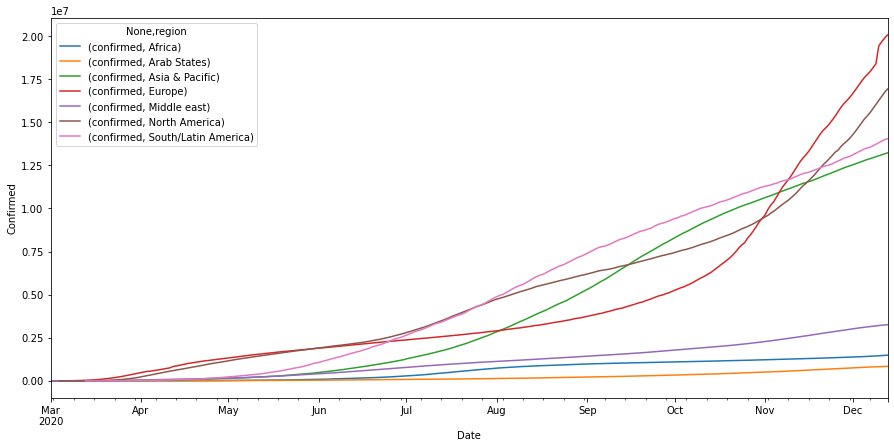

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_new.groupby(['date','region'])[['confirmed']].sum().unstack().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')

# hasil plot pada sumbu y dikali 1e7 atau 10^7

## 3.2. Plot orang terkonfirmasi Covid-19 tiap kelompok iklim

Text(0, 0.5, 'Confirmed')

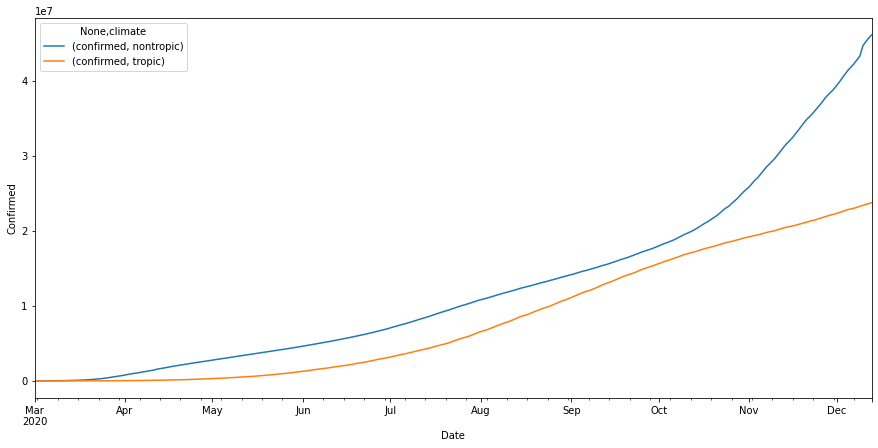

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_new.groupby(['date','climate'])[['confirmed']].sum().unstack().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')

# hasil plot pada sumbu y dikali 1e7 atau 10^7

## 3.3 Daftar 10 negara dengan kasus kematian tertinggi dari kasus-kasus pada tanggal terakhir di data hasil filter sebelumnya

In [13]:
# Kita buat dataframe 'df_last' yang hanya mengandung data tanggal terakhir dari 'df_new', 
# di mana tiap row menunjukkan data 'confirmed', 'deaths', 'recovered', 'region', dan 'climate' untuk 1 negara.
df_last = df_new[df_new['date']=="2020-12-13"]
df_last = df_last.drop(['date'],axis=1)
df_last.head()

,country,confirmed,deaths,recovered,region,climate
326,Afghanistan,48952.0,1960.0,38250.0,Asia & Pacific,nontropic
954,Albania,48530.0,1003.0,24820.0,Europe,nontropic
1582,Algeria,92102.0,2596.0,60457.0,Arab States,nontropic
2210,Andorra,7338.0,79.0,6629.0,Europe,nontropic
2838,Angola,16188.0,371.0,8898.0,Africa,tropic


Text(0, 0.5, 'Deaths')

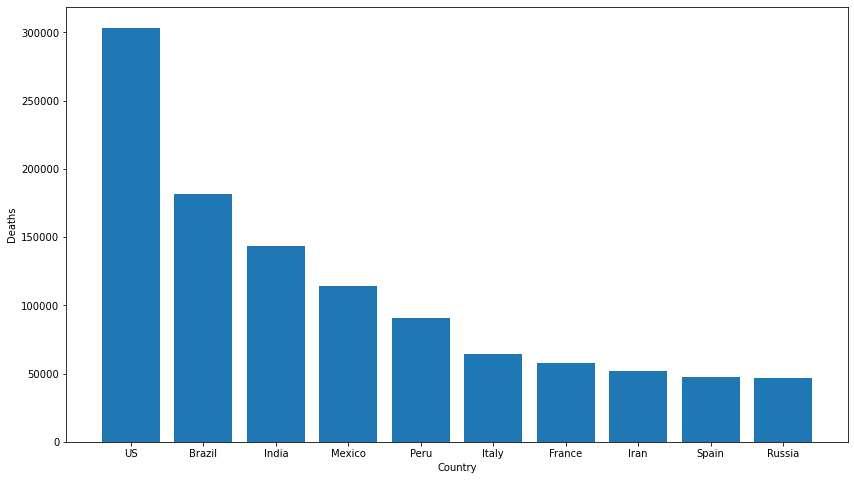

In [14]:
# Berdasarkan df_last, kita identifikasi 10 negara dengan data 'deaths' tertinggi. Buat barplotnya.

df_last_top10 = df_last.sort_values(by=['deaths'], ascending=False).head(10)

fig,ax = plt.subplots(figsize=(14,8))
plt.bar(df_last_top10['country'],df_last_top10['deaths'])
ax.set_xlabel('Country')
ax.set_ylabel('Deaths')

## 3.4 Penambahan kolom baru pada data sebelumnya dengan berisi beberapa perhitungan:

### 1. Kolom 'active_case' yang merupakan hasil perhitungan 'confirmed' dikurangi 'recovered' dan 'deaths'.
### 2. Kolom 'active_case_%' yang merupakan hasil perhitungan 'active_case' dibagi 'confirmed' dikali 100.
### 3. Kolom 'deaths_%' yang merupakan hasil perhitungan 'deaths' dibagi 'confirmed' dikali 100.
### 4. Kolom 'recovered_%' yang merupakan hasil perhitungan 'recovered' dibagi 'confirmed' dikali 100.

In [15]:
df_last['active_case']=df_last['confirmed']-(df_last['recovered']+df_last['deaths'])
df_last['active_case_%']=(df_last['active_case']/df_last['confirmed'])*100
df_last['deaths_%']=(df_last['deaths']/df_last['confirmed'])*100
df_last['recovered_%']=(df_last['recovered']/df_last['confirmed'])*100
df_last.head()

,country,confirmed,deaths,recovered,region,climate,active_case,active_case_%,deaths_%,recovered_%
326,Afghanistan,48952.0,1960.0,38250.0,Asia & Pacific,nontropic,8742.0,17.858310,4.003922,78.137768
954,Albania,48530.0,1003.0,24820.0,Europe,nontropic,22707.0,46.789615,2.066763,51.143623
1582,Algeria,92102.0,2596.0,60457.0,Arab States,nontropic,29049.0,31.540032,2.818614,65.641354
2210,Andorra,7338.0,79.0,6629.0,Europe,nontropic,630.0,8.585446,1.076588,90.337967
2838,Angola,16188.0,371.0,8898.0,Africa,tropic,6919.0,42.741537,2.291821,54.966642


## 3.5. Scatter matrix plot persentasi kasus aktif, kematian, dan kesembuhan tiap region dan iklim

array([[<AxesSubplot:xlabel='active_case_%', ylabel='active_case_%'>,
        <AxesSubplot:xlabel='deaths_%', ylabel='active_case_%'>,
        <AxesSubplot:xlabel='recovered_%', ylabel='active_case_%'>],
       [<AxesSubplot:xlabel='active_case_%', ylabel='deaths_%'>,
        <AxesSubplot:xlabel='deaths_%', ylabel='deaths_%'>,
        <AxesSubplot:xlabel='recovered_%', ylabel='deaths_%'>],
       [<AxesSubplot:xlabel='active_case_%', ylabel='recovered_%'>,
        <AxesSubplot:xlabel='deaths_%', ylabel='recovered_%'>,
        <AxesSubplot:xlabel='recovered_%', ylabel='recovered_%'>]],
      dtype=object)

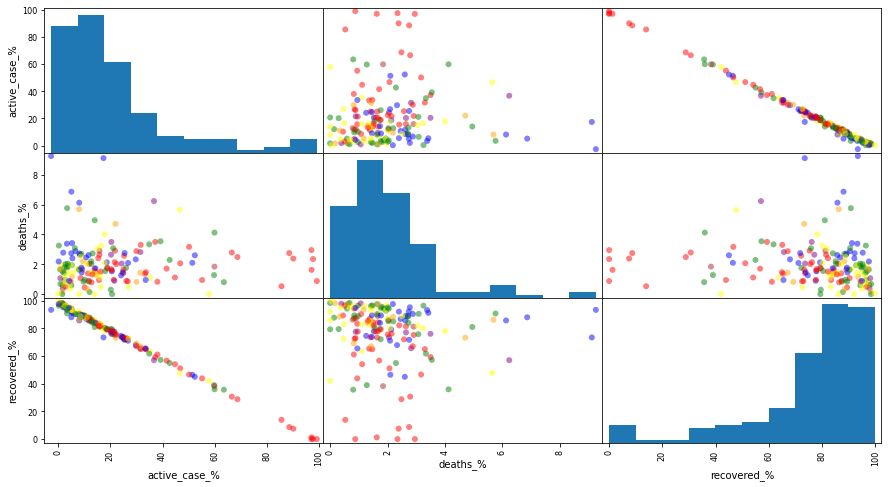

In [16]:
# Kita buat scatter matrix berdassarkan 'df_last' untuk 
# kolom 'active_case_%', 'deaths_%', dan 'recovered_%' (Warna scatter plot dibedakan berdasarkan region)

from pandas.plotting import scatter_matrix

colors_region = {'Europe':'red','Africa':'green','South/Latin America':'blue','Asia & Pacific':'yellow','Middle east':'orange', 'Arab States':'purple', 'North America':'brown'}

pd.plotting.scatter_matrix(df_last[['active_case_%','deaths_%','recovered_%']], alpha = 0.5, figsize = (15, 8), diagonal = 'hist', marker='o', c=df_last['region'].map(colors_region))


array([[<AxesSubplot:xlabel='active_case_%', ylabel='active_case_%'>,
        <AxesSubplot:xlabel='deaths_%', ylabel='active_case_%'>,
        <AxesSubplot:xlabel='recovered_%', ylabel='active_case_%'>],
       [<AxesSubplot:xlabel='active_case_%', ylabel='deaths_%'>,
        <AxesSubplot:xlabel='deaths_%', ylabel='deaths_%'>,
        <AxesSubplot:xlabel='recovered_%', ylabel='deaths_%'>],
       [<AxesSubplot:xlabel='active_case_%', ylabel='recovered_%'>,
        <AxesSubplot:xlabel='deaths_%', ylabel='recovered_%'>,
        <AxesSubplot:xlabel='recovered_%', ylabel='recovered_%'>]],
      dtype=object)

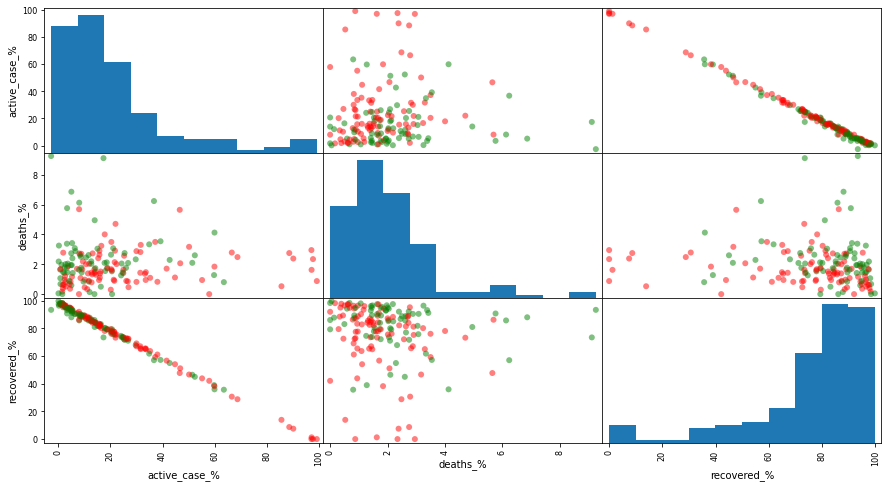

In [17]:
# Kita lakukan hal yang sama dengan membedakan warna scatter plot berdasarkan iklim.

colors_climate = {'nontropic':'red','tropic':'green'}

pd.plotting.scatter_matrix(df_last[['active_case_%','deaths_%','recovered_%']], alpha = 0.5, figsize = (15, 8), diagonal = 'hist', marker='o', c=df_last['climate'].map(colors_climate))


## 3.6. Test Pearson dan p-value untuk menguji korelasi atau hubungan linear antara data persentasi kasus aktif, kematian, dan kesembuhan

               active_case_%  deaths_%  recovered_%
active_case_%       1.000000  0.034203    -0.997663
deaths_%            0.034203  1.000000    -0.102413
recovered_%        -0.997663 -0.102413     1.000000


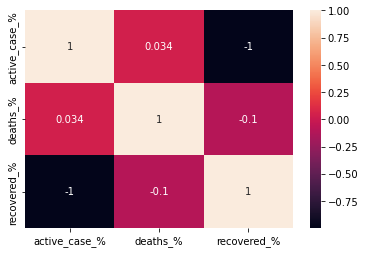

In [18]:
print (df_last[['active_case_%','deaths_%','recovered_%']].corr())
# Kita buat heatmap nya dengan seaborn
import seaborn as sns
sns.heatmap(df_last[['active_case_%','deaths_%','recovered_%']].corr(), annot=True);

### Kesimpulan : 

### Data active_case_% sangat berkorelasi negatif dengan data recovered_%. Hal ini terlihat dari nilai korelasi mereka dihasilkan nilai -0.997. Kita tahu bahwa nilai koefisien korelasi pearson berada di antara nilai -1<p<1 , di mana nilai 0 menandakan tidak ada korelasi sama sekali dan nilai 1 atau -1 menandakan total korelasi positif atau negatif. Untuk data deaths_% memiliki korelasi yang sama antara hubungan data deaths_% dengan active_case_%  atau dengan recovered_% yaitu senilai 0.03. Ini menandakan adanya korelasi namun tidak terlalu tinggi.

In [19]:
# P-value

from scipy import stats
pearson_coef1, p_value1 = stats.pearsonr(df_last['active_case_%'], df_last['deaths_%'])
pearson_coef2, p_value2 = stats.pearsonr(df_last['active_case_%'], df_last['recovered_%'])
pearson_coef3, p_value3 = stats.pearsonr(df_last['deaths_%'], df_last['recovered_%'])
print("Korelasi Pearson antara active_case_% dan deaths_%", pearson_coef1, " dengan P-value =", p_value1)  
print("Korelasi Pearson antara active_case_% dan recovered_%", pearson_coef2, " dengan P-value =", p_value2)
print("Korelasi Pearson antara deaths_% dan recovered_%", pearson_coef3, " dengan P-value =", p_value3)

Korelasi Pearson antara active_case_% dan deaths_% 0.03420279015254477  dengan P-value = 0.6637174562888603
Korelasi Pearson antara active_case_% dan recovered_% -0.9976627521520632  dengan P-value = 1.0113427233725161e-190
Korelasi Pearson antara deaths_% dan recovered_% -0.10241319306595471  dengan P-value = 0.19191631175112117


### Kesimpulan:

1. P-Value dari korelasi antara active_case_% dan deaths_% adalah 0.66371. Karena P-Value > 0.1 , maka tidak ada bukti bahwa korelasi mereka signifikan.

2. P-Value dari korelasi antara active_case_% dan recovered_% adalah 1.0113427233958369e-190. Karena P-Value < 0.001, maka bisa dikatakan terdapat bukti kuat bahwa korelasi mereka signifikan.

1. P-Value dari korelasi antara deaths_% dan recovered_% adalah 0.191916. Karena P-Value > 0.1 , maka tidak ada bukti (bukti lemah) bahwa korelasi mereka signifikan.


## 3.7 Test Anova untuk menguji hubungan linear antara data persentasi kasus aktif, kematian, dan kesembuhan

In [20]:
# region-active_case_%

from scipy.stats import f_oneway
CategoryGroupLists1=df_last.groupby('region')['active_case_%'].apply(list)
AnovaResults1 = f_oneway(*CategoryGroupLists1)
print('P-Value for Anova is: ', AnovaResults1[1])

P-Value for Anova is:  3.826063859655487e-06


In [21]:
# region-deaths_%

from scipy.stats import f_oneway
CategoryGroupLists2=df_last.groupby('region')['deaths_%'].apply(list)
AnovaResults2 = f_oneway(*CategoryGroupLists2)
print('P-Value for Anova is: ', AnovaResults2[1])

P-Value for Anova is:  0.005674002083079122


In [22]:
# region-recovered_%

from scipy.stats import f_oneway
CategoryGroupLists3=df_last.groupby('region')['recovered_%'].apply(list)
AnovaResults3 = f_oneway(*CategoryGroupLists3)
print('P-Value for Anova is: ', AnovaResults3[1])

P-Value for Anova is:  7.1621169013953965e-06


### Kesimpulan: Hubungan korelasi antara region dengan active_case, deaths,recovered cukup kuat dikarenakan nilai p-value yang semuanya hampir mendekati 0

## 3.8. Penambahan kolom safety dengan kriteria:

### Apabila data suatu negara memenuhi 'active_case_%' < 10, 'deaths_%' < 5, 'recovered_%' > 85 kita labeli negara ini dengan 'safe' pada kolom 'safety'. Apabila tidak memenuhi kriteria, kita labeli dengan 'not_safe'.

In [23]:
def conditions(s):
    if (s['active_case_%'] < 10) & (s['deaths_%'] < 5) & (s['recovered_%'] > 85):
        return 'safe'
    else:
        return 'not_safe'

In [24]:
df_last['safety']=df_last.apply(conditions,axis=1)
df_last.head()

,country,confirmed,deaths,recovered,region,climate,active_case,active_case_%,deaths_%,recovered_%,safety
326,Afghanistan,48952.0,1960.0,38250.0,Asia & Pacific,nontropic,8742.0,17.858310,4.003922,78.137768,not_safe
954,Albania,48530.0,1003.0,24820.0,Europe,nontropic,22707.0,46.789615,2.066763,51.143623,not_safe
1582,Algeria,92102.0,2596.0,60457.0,Arab States,nontropic,29049.0,31.540032,2.818614,65.641354,not_safe
2210,Andorra,7338.0,79.0,6629.0,Europe,nontropic,630.0,8.585446,1.076588,90.337967,safe
2838,Angola,16188.0,371.0,8898.0,Africa,tropic,6919.0,42.741537,2.291821,54.966642,not_safe


# 4. Model Machine Learning

## 4.1. Model Klasifikasi untuk memprediksi negara mana (Misal di antara negara Indonesia, US, Brazil, New Zealand, Singapore) yang aman berdasarkan kategori "safety"

In [25]:
new_df = df_last[(df_last['country']=='Indonesia')| (df_last['country']=='US')|(df_last['country']=='Brazil')|(df_last['country']=='New Zealand')|(df_last['country']=='Singapore')]
new_df

,country,confirmed,deaths,recovered,region,climate,active_case,active_case_%,deaths_%,recovered_%,safety
14770,Brazil,6901952.0,181402.0,6138349.0,South/Latin America,tropic,582201.0,8.435309,2.628271,88.936420,safe
48682,Indonesia,617820.0,18819.0,505836.0,Asia & Pacific,tropic,93165.0,15.079635,3.046033,81.874332,not_safe
77570,New Zealand,2096.0,25.0,2015.0,Asia & Pacific,nontropic,56.0,2.671756,1.192748,96.135496,safe
97666,Singapore,58320.0,29.0,58208.0,Asia & Pacific,tropic,83.0,0.142318,0.049726,99.807956,safe
112738,US,16463227.0,303463.0,6298082.0,North America,nontropic,9861682.0,59.901270,1.843278,38.255453,not_safe


In [26]:
# Karena target kita adalah safety maka kolom region dan country sebenarnya tidak terlalu relevan karena safety dipengaruhi nilai
# -nilai angka atau indeks kasus covid.

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data_fitur = df_last.drop(['country','region', 'safety', 'climate'],axis=1)

# scaling
stdscalar = StandardScaler()
data_scale = stdscalar.fit_transform(data_fitur)
fitur_scale = pd.DataFrame(data_scale,columns=data_fitur.columns)
fitur_scale.head()


,confirmed,deaths,recovered,active_case,active_case_%,deaths_%,recovered_%
0,-0.233650,-0.237823,-0.240653,-0.154237,-0.154613,1.336931,0.062484
1,-0.233912,-0.267214,-0.253778,-0.136722,1.176864,0.039071,-1.174032
2,-0.206905,-0.218290,-0.218951,-0.128767,0.475047,0.542797,-0.509937
3,-0.259443,-0.295592,-0.271556,-0.164411,-0.581369,-0.624328,0.621336
4,-0.253958,-0.286624,-0.269339,-0.156523,0.990563,0.189856,-0.998912


In [27]:
# label encoding label target (safety)

target_encoded= df_last[['safety']].copy()
for col in target_encoded.select_dtypes(include='O').columns:
    target_encoded [col]=le.fit_transform(target_encoded[col])
    
target_encoded.head()
# If we want to encode back : Y_pred_label = list(le.inverse_transform(target_encoded))

,safety
326,0
954,0
1582,0
2210,1
2838,0


### Misal di sini kita menggunakan model K-Nearest Neighbors

In [28]:
X=fitur_scale
y=target_encoded

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [29]:
# pembuatan model KNN
model_knn = KNeighborsClassifier(n_neighbors=15,weights='distance',leaf_size=34)
model_knn.fit(X_train,y_train)

/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(leaf_size=34, n_neighbors=15, weights='distance')

In [30]:
#akurasi model
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
y_pred = model_knn.predict(X_test)
print('Akurasi model pada data test:',accuracy_score(y_test,y_pred))

Akurasi model pada data test: 0.9696969696969697


### Confusion matrix of the prediction model

In [31]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

[[23  0]
 [ 1  9]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.90      0.95        10

    accuracy                           0.97        33
   macro avg       0.98      0.95      0.96        33
weighted avg       0.97      0.97      0.97        33



### Now we try using Gridsearch CV on our model

In [32]:
#Create the parameter grid based on the results of random search 
params_grid = {'n_neighbors': [5,10,15,20], 'weights': ['uniform','distance'],
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [33]:
knn_model = GridSearchCV(KNeighborsClassifier(), params_grid, cv=5,refit = True, verbose = 3,n_jobs=-1)
knn_model.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classif

/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/danielbeltsazar/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/sklearn/neighbors/_classif

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [5, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             verbose=3)

#### We got optimal parameters:

In [34]:
print(knn_model.best_params_)

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}


In [35]:
# View the accuracy score
print('Best score for training data:', knn_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best algorithm:',knn_model.best_estimator_.algorithm,"\n") 
print('Best n_neighbors:',knn_model.best_estimator_.n_neighbors,"\n")
print('Best weights:',knn_model.best_estimator_.weights,"\n")

Best score for training data: 0.9615384615384617 

Best algorithm: auto 

Best n_neighbors: 5 

Best weights: uniform 



In [36]:
final_model = knn_model.best_estimator_
y_pred2 = final_model.predict(X_test)

### Confusion matrix of our gridsearch model

In [37]:
print(confusion_matrix(y_test,y_pred2))
print("\n")
print(classification_report(y_test,y_pred2))

[[23  0]
 [ 2  8]]


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.80      0.89        10

    accuracy                           0.94        33
   macro avg       0.96      0.90      0.92        33
weighted avg       0.94      0.94      0.94        33



### Kita buat dataframe baru untuk negara Indonesia, US, Brazil, New Zealand, Singapore untuk dilakukan prediksi

In [38]:
new_df = df_last[(df_last['country']=='Indonesia')| (df_last['country']=='US')|(df_last['country']=='Brazil')|(df_last['country']=='New Zealand')|(df_last['country']=='Singapore')]
new_df

,country,confirmed,deaths,recovered,region,climate,active_case,active_case_%,deaths_%,recovered_%,safety
14770,Brazil,6901952.0,181402.0,6138349.0,South/Latin America,tropic,582201.0,8.435309,2.628271,88.936420,safe
48682,Indonesia,617820.0,18819.0,505836.0,Asia & Pacific,tropic,93165.0,15.079635,3.046033,81.874332,not_safe
77570,New Zealand,2096.0,25.0,2015.0,Asia & Pacific,nontropic,56.0,2.671756,1.192748,96.135496,safe
97666,Singapore,58320.0,29.0,58208.0,Asia & Pacific,tropic,83.0,0.142318,0.049726,99.807956,safe
112738,US,16463227.0,303463.0,6298082.0,North America,nontropic,9861682.0,59.901270,1.843278,38.255453,not_safe


In [39]:
df_newpred = new_df.drop(['country','region', 'safety','climate'],axis=1)

safety_pred = model_knn.predict(df_newpred)
safety_pred

array([0, 0, 0, 0, 0])

In [40]:
new_df['safety_prediksi_']='not_safe'
new_df.head()

/var/folders/52/_h12ds1j0_5c854m0gwwj0y80000gn/T/ipykernel_9081/537474386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['safety_prediksi_']='not_safe'


,country,confirmed,deaths,recovered,region,climate,active_case,active_case_%,deaths_%,recovered_%,safety,safety_prediksi_
14770,Brazil,6901952.0,181402.0,6138349.0,South/Latin America,tropic,582201.0,8.435309,2.628271,88.936420,safe,not_safe
48682,Indonesia,617820.0,18819.0,505836.0,Asia & Pacific,tropic,93165.0,15.079635,3.046033,81.874332,not_safe,not_safe
77570,New Zealand,2096.0,25.0,2015.0,Asia & Pacific,nontropic,56.0,2.671756,1.192748,96.135496,safe,not_safe
97666,Singapore,58320.0,29.0,58208.0,Asia & Pacific,tropic,83.0,0.142318,0.049726,99.807956,safe,not_safe
112738,US,16463227.0,303463.0,6298082.0,North America,nontropic,9861682.0,59.901270,1.843278,38.255453,not_safe,not_safe


## 4.2. Model Regresi Linear untuk memplot dan memprediksi persentasi kasus aktif (active_case_%)

In [41]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X_new = df_last.drop(['country','region', 'safety','climate','active_case_%'],axis=1)
y_new = df_last['active_case_%']
X_Train, X_Test, y_Train, y_Test = train_test_split(X_new, y_new, test_size=0.2, random_state=21)

In [42]:
lr.fit(X_Train,y_Train)

LinearRegression()

In [43]:
print('intercept : ',lr.intercept_)
print('slope :',lr.coef_)

intercept :  99.99999999999979
slope : [ 4.91557539e-12 -4.91549218e-12 -4.91557673e-12 -4.91557712e-12
 -1.00000000e+00 -1.00000000e+00]


In [44]:
y_Pred = lr.predict(X_Test)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_Test, y_Pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_Test, y_Pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_Test, y_Pred)))

Mean Absolute Error: 4.59508693721618e-13
Mean Squared Error: 1.2649944006356915e-24
Root Mean Squared Error: 1.1247196986963869e-12


Text(0, 0.5, 'active_case_%')

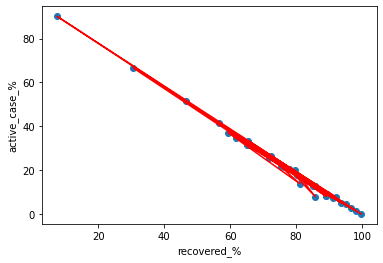

In [45]:
# Akan sulit diplot karena data train terdiri dari banyak dimensi. Saya belum tahu caranya.
# Namun di sini saya coba tampilkan data asli recovered_% dengan hasil regresi yaitu active_case_% beserta plot regresinya
plt.scatter(X_Test['recovered_%'], y_Test)
plt.plot(X_Test['recovered_%'], y_Pred, c='r')
plt.xlabel('recovered_%')
plt.ylabel('active_case_%')


## 4.3. Model Clustering untuk memprediksi nomor cluster berdasarkan data 'active_case_%', 'deaths_%', dan 'recovered_%'

In [46]:
# kita gunakan batasan 5 cluster

from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=5,init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(df_last[['active_case_%','deaths_%','recovered_%']])

KMeans(n_clusters=5, random_state=0)

In [47]:
kmeans.cluster_centers_

array([[35.30222595,  2.27816793, 62.41960612],
       [ 5.61868643,  1.88215849, 92.49915509],
       [56.82812199,  2.29622568, 40.87565233],
       [19.11673023,  2.02601577, 78.857254  ],
       [93.59666273,  1.92329552,  4.48004175]])

### Misal kita ingin menggunakan model clustering tersebut untuk memprediksi cluster beberapa negara:

##### i. Indonesia
##### ii. Singapore
##### iii. US
##### iv. Italy
##### v. Iran

In [48]:
df_cluster = df_last[(df_last['country']=='Indonesia')| (df_last['country']=='Singapore')|(df_last['country']=='US')|(df_last['country']=='Italy')|(df_last['country']=='Iran')]
df_cluster

,country,confirmed,deaths,recovered,region,climate,active_case,active_case_%,deaths_%,recovered_%,safety
48682,Indonesia,617820.0,18819.0,505836.0,Asia & Pacific,tropic,93165.0,15.079635,3.046033,81.874332,not_safe
49310,Iran,1108269.0,52196.0,812270.0,Middle east,nontropic,243803.0,21.998540,4.709687,73.291773,not_safe
51822,Italy,1843712.0,64520.0,1093161.0,Europe,nontropic,686031.0,37.209228,3.499462,59.291310,not_safe
97666,Singapore,58320.0,29.0,58208.0,Asia & Pacific,tropic,83.0,0.142318,0.049726,99.807956,safe
112738,US,16463227.0,303463.0,6298082.0,North America,nontropic,9861682.0,59.901270,1.843278,38.255453,not_safe


In [49]:
y_kmeans = kmeans.predict(df_cluster[['active_case_%','deaths_%','recovered_%']])
y_kmeans

AttributeError: 'NoneType' object has no attribute 'split'

### Kesimpulan:
1. Indonesia : Cluster 3
2. Iran     : Cluster 3
3. Italy    : Cluster 0
4. Singapore : Cluster 1
5. US        : Cluster 2

### Misal kita buat plot 3d dari model clustering yang telah dibuat

In [ ]:
z = df_last[['active_case_%', 'deaths_%', 'recovered_%']].values

In [ ]:
y_clusters = kmeans.fit_predict(z)

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z[y_clusters == 0,0],z[y_clusters == 0,1],z[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(z[y_clusters == 1,0],z[y_clusters == 1,1],z[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(z[y_clusters == 2,0],z[y_clusters == 2,1],z[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(z[y_clusters == 3,0],z[y_clusters == 3,1],z[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 3")
ax.scatter(z[y_clusters == 4,0],z[y_clusters == 4,1],z[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.set_xlabel('Active case %')
ax.set_ylabel('Deaths %')
ax.set_zlabel('Recovered %')
ax.legend()
plt.show()